# DigiLab 4 - Unit Commitment 
Author: Emil G. Melfald, University of South-Eastern Norway <br><br>

The Unit Commitment (UC) problem represents a computational task in power system operations aimed at determining the optimal start-up and shut-down schedule of generating units to meet forecasted demand while adhering to various system constraints. This problem is essentially combinatorial, and is traditionally falling in the time frame of one day to one week ahead.

The primary motivation for solving the UC problem is twofold:
1. Economic Efficiency: To minimize the total generation cost, including fuel costs, start-up and shut-down costs.
2. Operational Reliability: To ensure that the system meets demand while satisfying various physical and regulatory constraints such as ramp rates, minimum up/down times, and reserve requirements.

#### Relationship to Economic Dispatch and Optimal Power Flow
- **Economic Dispatch (ED)**: While UC determines which units should be on or off, Economic Dispatch optimizes the output levels of the committed units to minimize fuel costs, often assuming the commitment decisions as given.

- **Optimal Power Flow (OPF)**: Extending the scope of Economic Dispatch, OPF aims to optimize the power flows in a network considering network constraints like transmission limits and voltage levels. OPF incorporates both UC and ED but is usually more computationally intensive.

In summary, UC feeds into ED, which subsequently can be integrated into OPF, forming a hierarchical structure for power system optimization. Each problem introduces a layer of complexity and constraint that guides the operation of an efficient and reliable electric power system. By solving these problems in a coherent and integrated manner, one can navigate the trade-offs between economic efficiency and operational reliability, thereby achieving an optimal power system configuration.

This notebook is the first of three that will help you understand UC, ED, and OPF. This first notebook will teach you to use PyPSA for Unit Commitment (UC) calculations. We will investigate how we may inform the UC with different cost data, and how we constrain the UC with rise/fall times, and minimum up- and down times. 

**Note**: PyPSA documentation and explanations for keywords when defining grid components is found [here](https://pypsa.readthedocs.io/en/latest/components.html). For more examples on UC, visit [PyPSA UC Example](https://pypsa.readthedocs.io/en/latest/examples/unit-commitment.html). 
## Prerequisites 
You must have completed **Assignment 1** in the EPE2316 course. That also includes Digilab 1 to 3. Familiarity with UC from the lectures is adviced. 

## Learning Objectives 
By the end of this notebook you should be able to: 
- Formulate and solve UC in PyPSA 
- Add cost data to generating units 
- Add UC constraints 
- Solve the UC problem with both dispatchable and non-dispatchable units
- Visualize UC result data 

## Contents 
1. [UC With no constraints](#UCNoCon)
2. [UC With startup and shutdown cost](#UCStartup)
3. [Adding minimum and maximum uptime](#UCUptime) 
4. [Adding min and max ramp rate](#UCRampRate) 
5. [Adding non-controllable generating units](#UCSolar) 

# [UC With no constraints](#UCNoCon)
Assume the following grid, which is almost equivalent to the grid you constructed in **Assignment 1**.

![Image of the power system under study](Power_System_Drawing.png)

In [67]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os

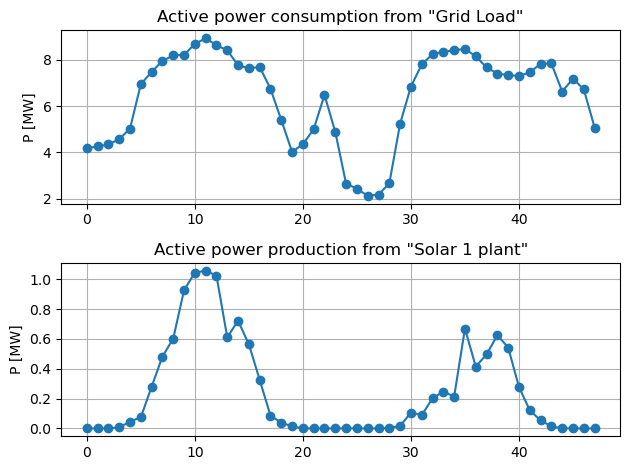

In [43]:
# To evaluate the UC we need a load profile 
load_data = pd.read_csv("load_data.csv") # Load the data into a pandas dataframe
solar_data = pd.read_csv("solar_data.csv") # Also loads in a solar production profile for later use 

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(load_data["Hour"].values, load_data["P load [MW]"], 'o-')
ax1.grid()
ax1.set_title("Active power consumption from \"Grid Load\"")
ax1.set_ylabel("P [MW]")

ax2.plot(solar_data["Hour"].values, solar_data["P [MW]"], 'o-')
ax2.grid()
ax2.set_title("Active power production from \"Solar 1 plant\"")
ax2.set_ylabel("P [MW]")

plt.tight_layout()
plt.show() 

In [90]:
# Define a function that creates our network (useful because we are doing this many times over)
def create_network_wo_solar(G1_data, G2_data): 
    V_base = 22 
    network = pypsa.Network(snapshots=range(len(load_data["P load [MW]"].values))) # Tells PyPSA how many datapoints should be considered
    network.add("Bus", "Bus 1", v_nom=V_base)
    network.add("Bus", "Bus 2", v_nom=V_base)
    network.add("Bus", "Bus 3", v_nom=V_base)
    network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
    network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
    network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

    network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, p_nom=G1_data["p_nom"], p_min_pu=G1_data["p_min_pu"], 
                marginal_cost=G1_data["marginal_cost"], start_up_cost=G1_data["start_up_cost"], 
                shut_down_cost=G1_data["shut_down_cost"], min_up_time=G1_data["min_up_time"], min_down_time=G1_data["min_down_time"], 
                ramp_limit_up=G1_data["ramp_limit_up"], ramp_limit_down=G1_data["ramp_limit_down"])
    
    network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, p_min_pu=G2_data["p_min_pu"], p_nom=G2_data["p_nom"],
                marginal_cost=G2_data["marginal_cost"], start_up_cost=G2_data["start_up_cost"], 
                shut_down_cost=G2_data["shut_down_cost"], min_up_time=G2_data["min_up_time"], min_down_time=G2_data["min_down_time"], 
                ramp_limit_up=G2_data["ramp_limit_up"], ramp_limit_down=G2_data["ramp_limit_down"])

    network.add("Load", "Load 1", bus="Bus 2", p_set=load_data["P load [MW]"].values)
    return network 

# Creating a general plotter function, as this will be useful throughout the notebook 
def plot_grid_dispatch_wo_solar(network, G1_data, G2_data): 
    # Assumes the network has been successfully optimized 
    G1_P = network.generators_t.p["Hydro 1"].values
    G2_P = network.generators_t.p["Hydro 2"].values
    G1_status = network.generators_t.status["Hydro 1"].values
    G2_status = network.generators_t.status["Hydro 2"].values
    spinning_cap = G1_data["p_nom"]*G1_status + G2_data["p_nom"]*G2_status 

    plt.plot(G1_P, 'o-', label="Hydro 1 [MW]", color="blue")
    plt.plot(G2_P, 'o-', label="Hydro 2 [MW]", color="orange")
    plt.plot(load_data["P load [MW]"].values, 'o-', label="Demand [MW]", color="red")
    plt.plot(G1_status, linewidth=4, label="Hydro 1 status", color="black")
    plt.plot(G2_status, linewidth=3, label="Hydro 2 status", color="grey")
    plt.plot(spinning_cap, 'o-', label="Spinning capacity", color="green")
    plt.legend(loc="upper left", fontsize=7) 
    plt.grid() 

    plt.xlabel("Time [hour]")
    plt.ylabel("Dispatch/demand [MW]")
    plt.show() 

# Makes a function that solves UC and plots it, based on given generator constraints
def calc_and_show_UC_wo_solar(G1_data, G2_data): 
    log_file = "solver_log.txt"
    network = create_network_wo_solar(G1_data, G2_data) 
    with open(log_file, "w") as f: # Use this to remove PyPSA printed output  
        sys.stdout = f
        sys.stderr = f
        network.optimize()  # Run the optimization
    sys.stdout = sys.__stdout__  # Reset stdout to its default
    sys.stderr = sys.__stderr__  # Reset stderr to its default
    plot_grid_dispatch_wo_solar(network, G1_data, G2_data)

The **marginal_cost** keywork is related to the cost function that is to be minimized. In fact, it is the factor $C_i$ in the following linear cost function (from the lecture). 

$$ \min_{\{P_i, u_i\}} \sum_{i=1}^{N} u_i C_i P_i $$

PyPSA will automatically enforce the load balance constraint when calling **network.optimize()**. 

$$ \sum_{i=1}^{N} P_g^i = P_{load}$$

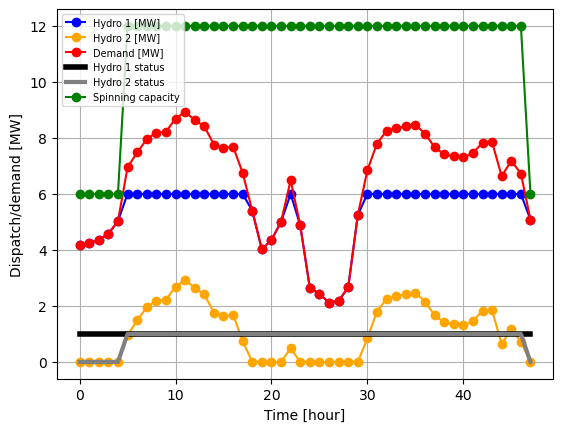

In [91]:
G1_data = {"p_nom": 6, 
           "p_min_pu": 0.0, 
           "marginal_cost": 50, 
           "start_up_cost": 0.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

G2_data = {"p_nom": 6, 
           "p_min_pu": 0.0, 
           "marginal_cost": 100, 
           "start_up_cost": 0.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

calc_and_show_UC_wo_solar(G1_data, G2_data)

The **p_min_pu** and **p_max_pu** keywords may be used to enforce additional constraints on the generating units. 

$$ u_i P_i^{min} \le P_i \le u_i P_i^{max} $$ 

Shown below is the case where we set **p_min_pu** to 0.2 pu. 

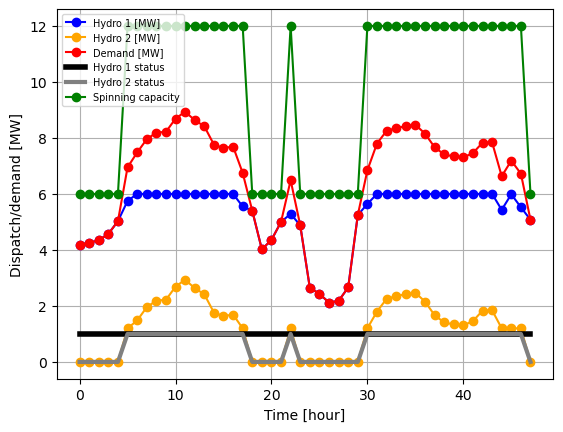

In [92]:
G1_data["p_min_pu"] = 0.2
G2_data["p_min_pu"] = 0.2
calc_and_show_UC_wo_solar(G1_data, G2_data)

# [UC With startup and shutdown cost](#UCStartup)
The keyword argument **start_up_cost** can be added when adding the generator units. If we set the startup costs of both units to 1000 NOK then the UC results will change to both units being on at all times. 

The startup and shutdown costs affects the cost function by an additional term $s_i^t$. This $s_i^t$ is equal to the specified **start_up_cost** when a unit goes from *not commited* to *commited*. The same goes for the **shut_down_cost** argument. 

$$ \min_{\{P_i, u_i, s_i^t\}} \sum_{i=1}^{N} u_i C_i P_i + s_i^t $$

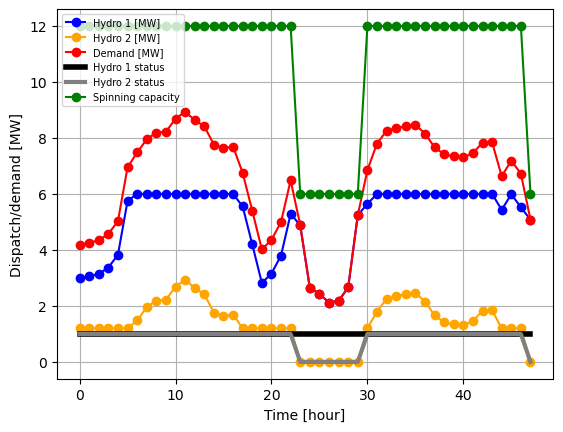

In [93]:
G1_data = {"p_nom": 6, 
           "p_min_pu": 0.2, 
           "marginal_cost": 50, 
           "start_up_cost": 1000.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

G2_data = {"p_nom": 6, 
           "p_min_pu": 0.2, 
           "marginal_cost": 100, 
           "start_up_cost": 1000.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

calc_and_show_UC_wo_solar(G1_data, G2_data)

The marginal cost may affect whether or not starting and stopping a unit repeatedly is profitable. Adjusting the **marginal_cost** to 300 makes it worth it to shut it down for shorter periods of time. 

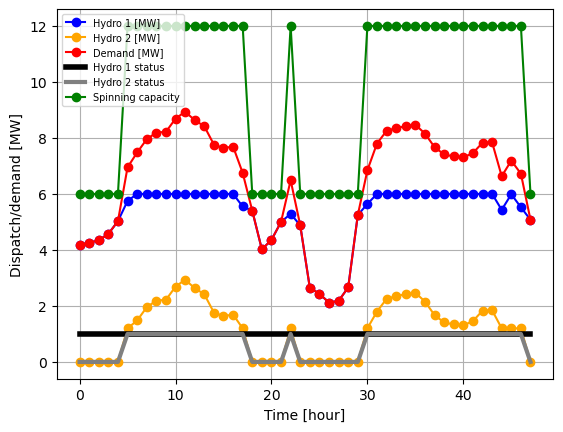

In [96]:
G2_data["marginal_cost"] = 300
calc_and_show_UC_wo_solar(G1_data, G2_data)

# [Adding minimum and maximum uptime](#UCUptime)
The **min_up_time** and **min_down_time** adjusts how long we require a generator to be on or off after changing its status. This is mathematically related to the following constraint in the UC problem. 

- Must stay on for $L_i$ periods: 
$$ u_i^t - u_i^{t-1} \le u_i^\tau, \tau = t+1, ..., \min\{t+L_i-1, T\} $$

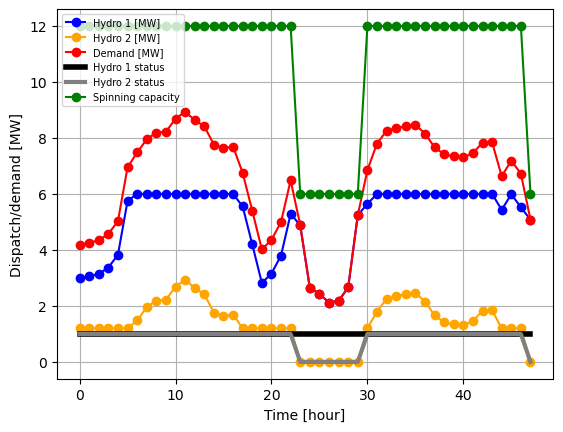

In [97]:
G1_data = {"p_nom": 6, 
           "p_min_pu": 0.2, 
           "marginal_cost": 50, 
           "start_up_cost": 1000.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

G2_data = {"p_nom": 6, 
           "p_min_pu": 0.2, 
           "marginal_cost": 100, 
           "start_up_cost": 1000.0, 
           "shut_down_cost": 0.0, 
           "min_up_time": 0.0, 
           "min_down_time": 0.0, 
           "ramp_limit_up": 1.0, 
           "ramp_limit_down": 1.0} 

calc_and_show_UC_wo_solar(G1_data, G2_data)

# [Adding min and max ramp rate](#UCRampRate) 

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 528 primals, 0 duals
Objective: 2.09e+04
Solver model: not available
Solver message: integer optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\emelf\AppData\Local\Temp\linopy-problem-7kjd2q0i.lp --output
 C:\Users\emelf\AppData\Local\Temp\linopy-solve-lx6z48jf.sol
Reading problem data from 'C:\Users\emelf\AppData\Local\Temp\linopy-problem-7kjd2q0i.lp'...
1052 rows, 528 columns, 2524 non-zeros
288 integer variables, all of which are binary
6311 lines were read
GLPK Integer Optimizer 5.0
1052 rows, 528 columns, 2524 non-zeros
288 integer variables, all of which are binary
Preprocessing...
14 hidden packing inequaliti(es) were detected
727 rows, 493 columns, 2075 non-zeros
253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.231e+03  ratio =  7.231e+03
GM: min|aij| =  5.814e-01  max|aij| =  1.720e+00  ratio =  2.958e+00
EQ: min|aij| =  3.381e-01  max|aij| =  1.000e+00  ratio =  2.958e+00
2N: min|aij| =  2.500e-01  max|aij| =  1.250e+00  ratio =  5.000e+00
Constructing initial basis...
Size of tr

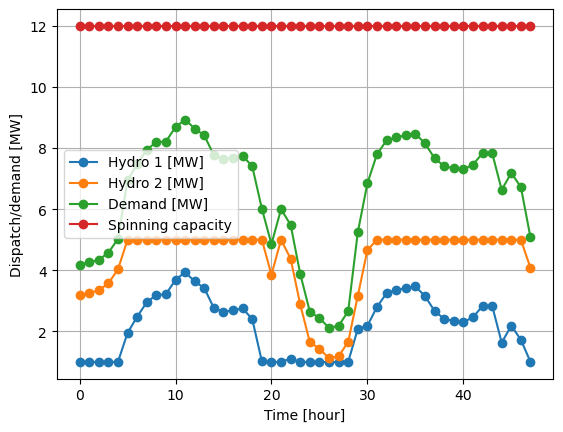

In [146]:
network = pypsa.Network(snapshots=range(len(P_load))) 

network.add("Bus", "Bus 1", v_nom=V_base)
network.add("Bus", "Bus 2", v_nom=V_base)
network.add("Bus", "Bus 3", v_nom=V_base)
network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, p_min_pu=0.2, p_nom=5, marginal_cost=100, 
            ramp_limit_up=0.3, ramp_limit_down=0.3, ramp_limit_start_up=0.5)

network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, p_min_pu=0.2, p_nom=5, marginal_cost=50, 
            ramp_limit_up=0.3, ramp_limit_down=0.3)

network.add("Load", "Load 1", bus="Bus 2", p_set=P_load)
info = network.optimize()

G1_P = network.generators_t.p["Hydro 1"].values
G2_P = network.generators_t.p["Hydro 2"].values
G1_status = network.generators_t.status["Hydro 1"].values
G2_status = network.generators_t.status["Hydro 2"].values

plt.plot(G1_P, 'o-', label="Hydro 1 [MW]")
plt.plot(G2_P, 'o-', label="Hydro 2 [MW]")
plt.plot(P_load, 'o-', label="Demand [MW]")
plt.plot(G1_status*5.0 + G2_status*7.0, 'o-', label="Spinning capacity")
plt.legend() 
plt.grid() 

plt.xlabel("Time [hour]")
plt.ylabel("Dispatch/demand [MW]")
plt.show() 

# [Adding non-controllable generating units](#UCSolar) 
Assume that at Bus 2 there is now installed a large solar array. The generation data for two days is given in the **solar_data.csv** file. 

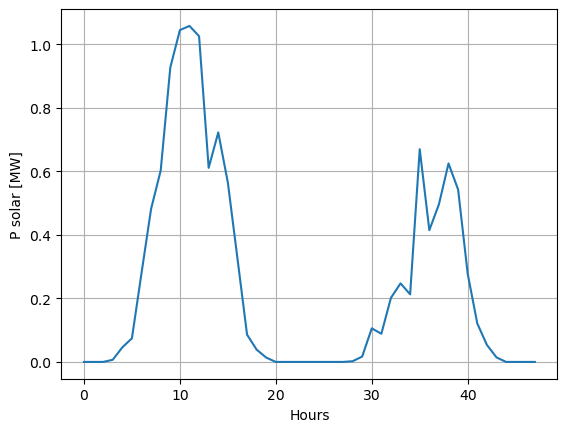

In [149]:
P_solar = pd.read_csv("solar_data.csv")
plt.plot(P_solar["hour"], P_solar["P [MW]"])
plt.grid() 
plt.ylabel("P solar [MW]")
plt.xlabel("Hours")
plt.show() 

In [158]:
P_solar["P [MW]"].values

array([0.       , 0.       , 0.       , 0.0067375, 0.0458625, 0.0743   ,
       0.2797125, 0.4822875, 0.60275  , 0.9271625, 1.0452   , 1.058275 ,
       1.025825 , 0.611275 , 0.72285  , 0.564825 , 0.326075 , 0.0860375,
       0.0386625, 0.01355  , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.0021625, 0.0167625,
       0.10575  , 0.0887   , 0.2018875, 0.247425 , 0.2128875, 0.669925 ,
       0.415    , 0.4963375, 0.625175 , 0.5428875, 0.2776   , 0.121075 ,
       0.0536625, 0.0142   , 0.       , 0.       , 0.       , 0.       ])

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 576 primals, 0 duals
Objective: 1.91e+04
Solver model: not available
Solver message: integer optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\emelf\AppData\Local\Temp\linopy-problem-lsnvavjb.lp --output
 C:\Users\emelf\AppData\Local\Temp\linopy-solve-8_7qw0q0.sol
Reading problem data from 'C:\Users\emelf\AppData\Local\Temp\linopy-problem-lsnvavjb.lp'...
1008 rows, 576 columns, 1964 non-zeros
288 integer variables, all of which are binary
5714 lines were read
GLPK Integer Optimizer 5.0
1008 rows, 576 columns, 1964 non-zeros
288 integer variables, all of which are binary
Preprocessing...
12 hidden packing inequaliti(es) were detected
555 rows, 507 columns, 1414 non-zeros
268 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.231e+03  ratio =  7.231e+03
GM: min|aij| =  5.814e-01  max|aij| =  1.720e+00  ratio =  2.958e+00
EQ: min|aij| =  3.381e-01  max|aij| =  1.000e+00  ratio =  2.958e+00
2N: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Constructing initial basis...
Size of tr

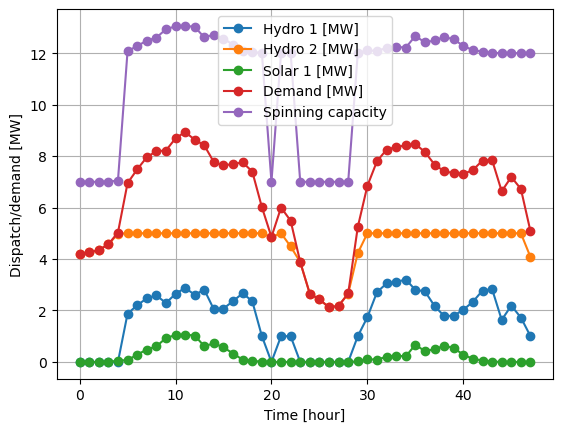

In [164]:
network = pypsa.Network(snapshots=range(len(P_load))) 

network.add("Bus", "Bus 1", v_nom=V_base)
network.add("Bus", "Bus 2", v_nom=V_base)
network.add("Bus", "Bus 3", v_nom=V_base)
network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, p_min_pu=0.2, p_nom=5, marginal_cost=100)
network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, p_min_pu=0.2, p_nom=5, marginal_cost=50)
network.add("Generator", "Solar 1", bus="Bus 2", committable=False, p_set=P_solar["P [MW]"].values, p_nom=2, 
            marginal_cost=5)

network.add("Load", "Load 1", bus="Bus 2", p_set=P_load)
info = network.optimize()

G1_P = network.generators_t.p["Hydro 1"].values
G2_P = network.generators_t.p["Hydro 2"].values
G3_P = network.generators_t.p["Solar 1"].values
G1_status = network.generators_t.status["Hydro 1"].values
G2_status = network.generators_t.status["Hydro 2"].values

plt.plot(G1_P, 'o-', label="Hydro 1 [MW]")
plt.plot(G2_P, 'o-', label="Hydro 2 [MW]")
plt.plot(G3_P, 'o-', label="Solar 1 [MW]")
plt.plot(P_load, 'o-', label="Demand [MW]")
plt.plot(G1_status*5.0 + G2_status*7.0 + G3_P, 'o-', label="Spinning capacity")
plt.legend() 
plt.grid() 

plt.xlabel("Time [hour]")
plt.ylabel("Dispatch/demand [MW]")
plt.show() 